# Projection, Joining, and Sorting

## Setup

In [1]:
import ibis
import os
hdfs_port = os.environ.get('IBIS_WEBHDFS_PORT', 50070)
hdfs = ibis.hdfs_connect(host='impala', port=hdfs_port)
con = ibis.impala.connect(host='impala', database='ibis_testing',
                          hdfs_client=hdfs)
print('Hello!')

Hello!


## Projections: adding/selecting columns

Projections are the general way for adding new columns to tables, or selecting or removing existing ones.

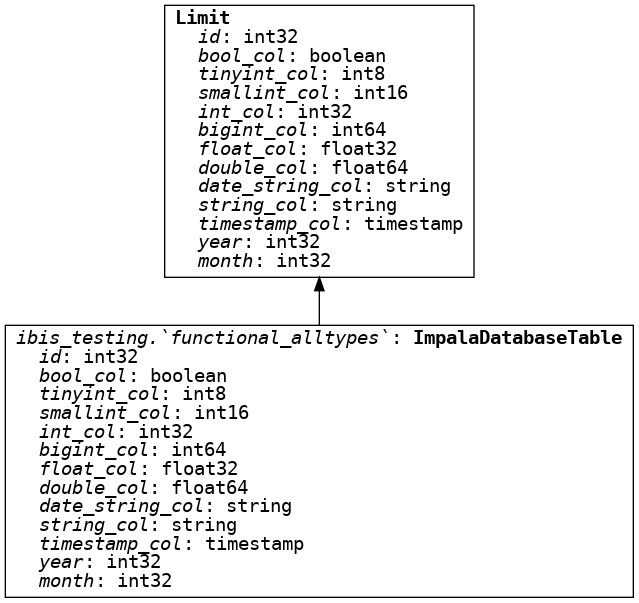

In [2]:
table = con.table('functional_alltypes')
table.limit(5)

First, the basics: selecting columns:

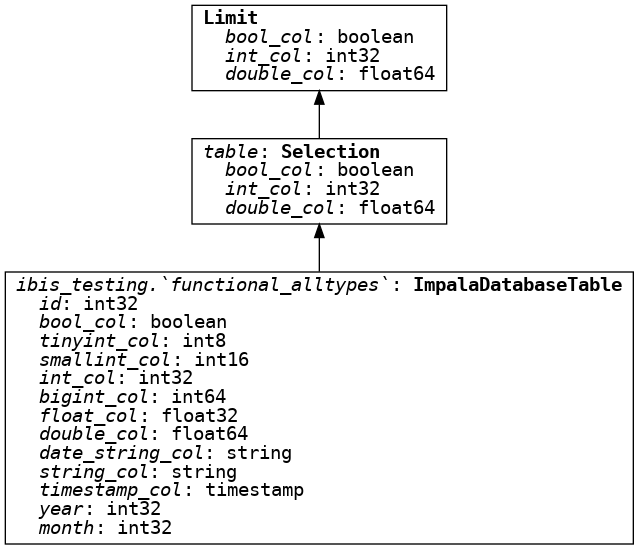

In [3]:
proj = table['bool_col', 'int_col', 'double_col']

proj.limit(5)

You can make a list of columns you want, too, and pass that:

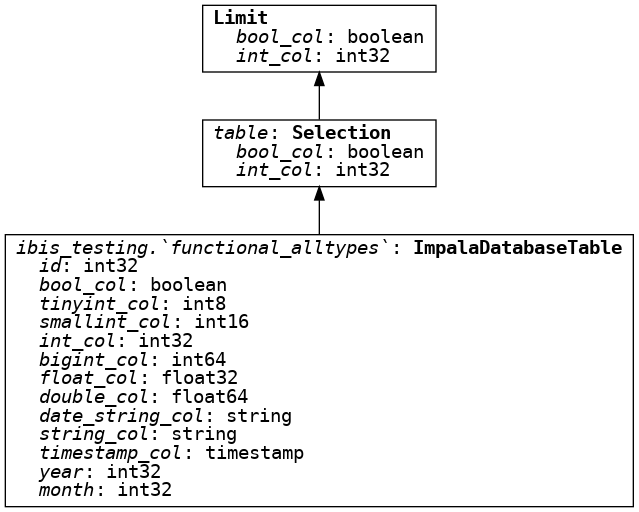

In [4]:
to_select = ['bool_col', 'int_col']
table[to_select].limit(5)

You can also use the explicit `projection` or `select` functions

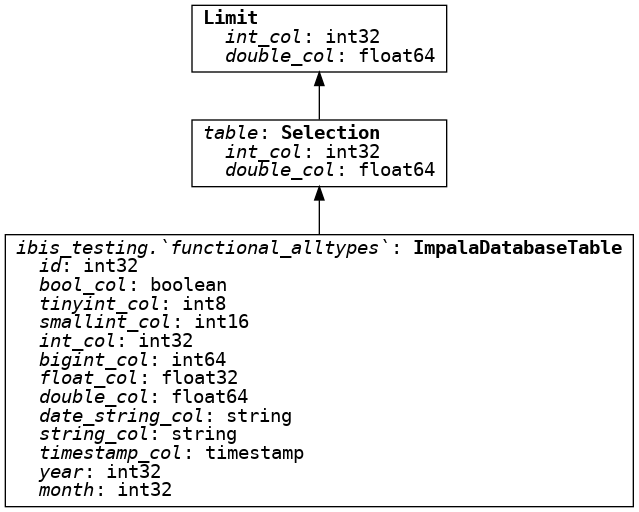

In [5]:
table.select(['int_col', 'double_col']).limit(5)

We can add new columns by using named column expressions

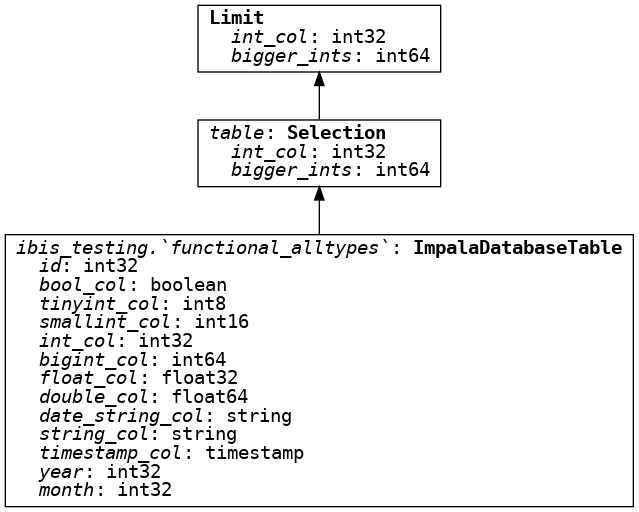

In [6]:
bigger_expr = (table.int_col * 2).name('bigger_ints')
proj2 = table['int_col', bigger_expr]
proj2.limit(5)

In more complicated projections involving joins, we may need to refer to all of the columns in a table at once. This is how `add_column` works. We just pass the whole table in the projection:

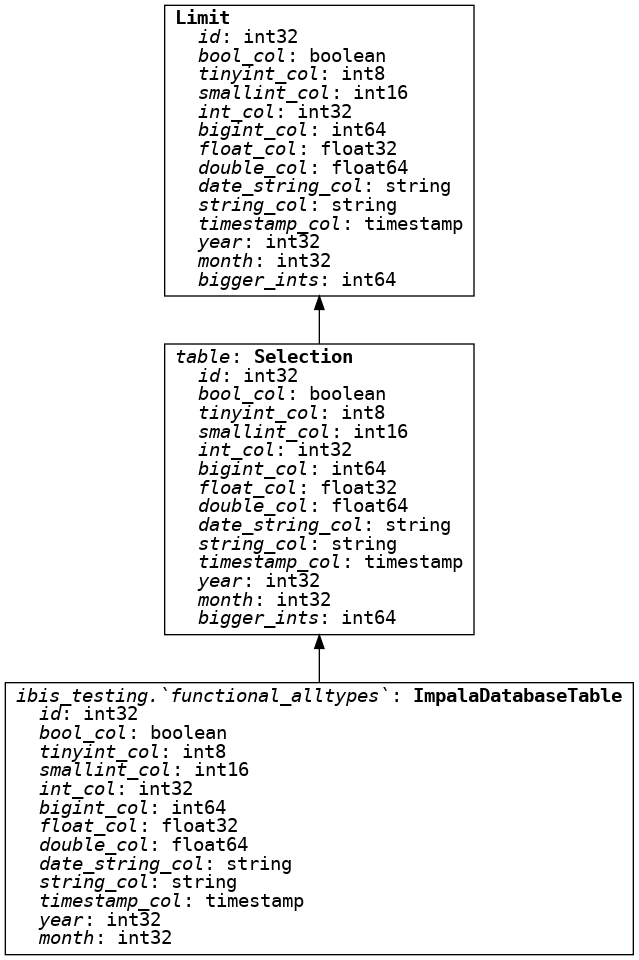

In [7]:
table.select([table, bigger_expr]).limit(5)


To use constants in projections, we have to use a special `ibis.literal` function

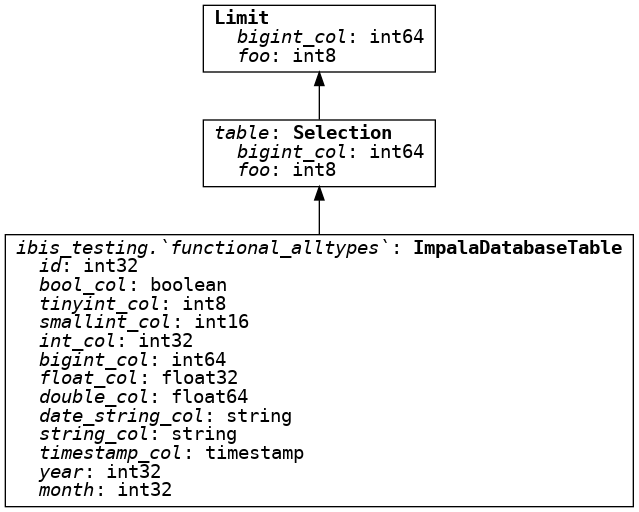

In [8]:
foo_constant = ibis.literal(5).name('foo')
table.select([table.bigint_col, foo_constant]).limit(5)

## Joins

Ibis attempts to provide good support for all the standard relational joins supported by Impala, Hive, and other relational databases.

- inner, outer, left, right joins
- semi and anti-joins

To illustrate the joins we'll use the TPC-H tables for now

In [9]:
region = con.table('tpch_region')
nation = con.table('tpch_nation')
customer = con.table('tpch_customer')
lineitem = con.table('tpch_lineitem')

`region` and `nation` are connected by their respective `regionkey` columns

In [10]:
join_expr = region.r_regionkey == nation.n_regionkey
joined = region.inner_join(nation, join_expr)

If you have multiple join conditions, either compose them yourself (like filters) or pass a list to the join function

    join_exprs = [cond1, cond2, cond3]
    joined = table1.inner_join(table2, join_exprs)

Once you've joined tables, you don't necessarily have anything yet. I'll put it in big letters

### Joins are declarations of intent

After calling the join function (which validates the join condition, of course), you may perform any number of other operations:

- Aggregation
- Projection
- Filtering

and so forth. Most importantly, depending on your schemas, the joined tables may include overlapping column names that could create a conflict if not addressed directly. Some other systems, like pandas, handle this by applying suffixes to the overlapping column names and computing the fully joined tables immediately. We don't do this.

So, with the above data, suppose we just want the region name and all the nation table data. We can then make a projection on the joined reference:

In [11]:
table_ref = joined[nation, region.r_name.name('region')]
table_ref.columns

['n_nationkey', 'n_name', 'n_regionkey', 'n_comment', 'region']

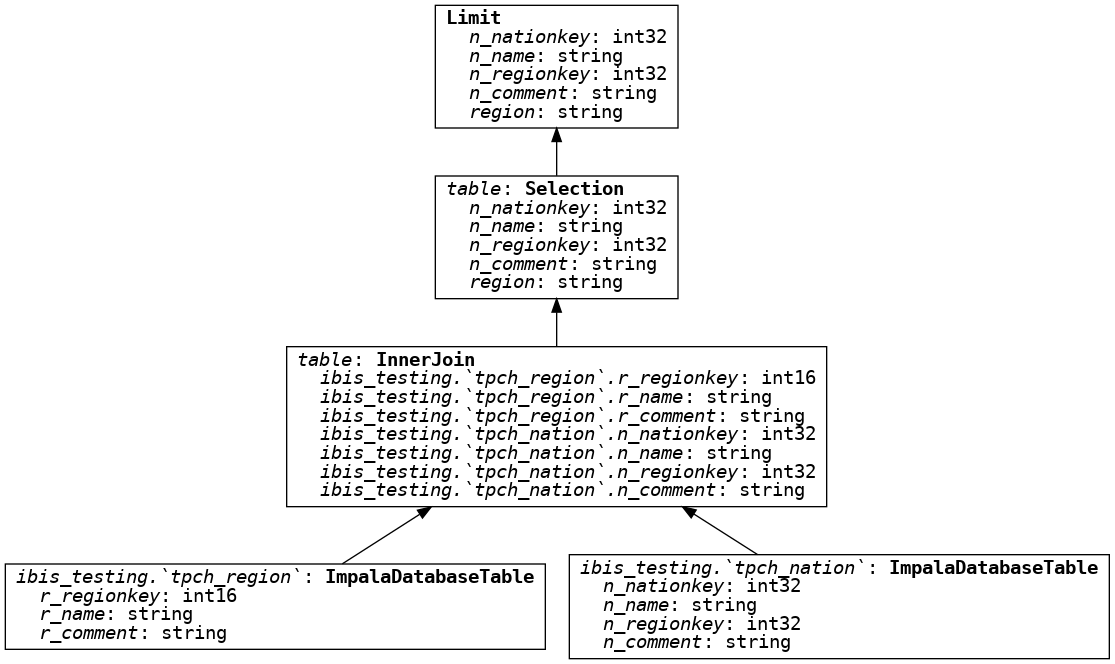

In [12]:
table_ref.limit(5)

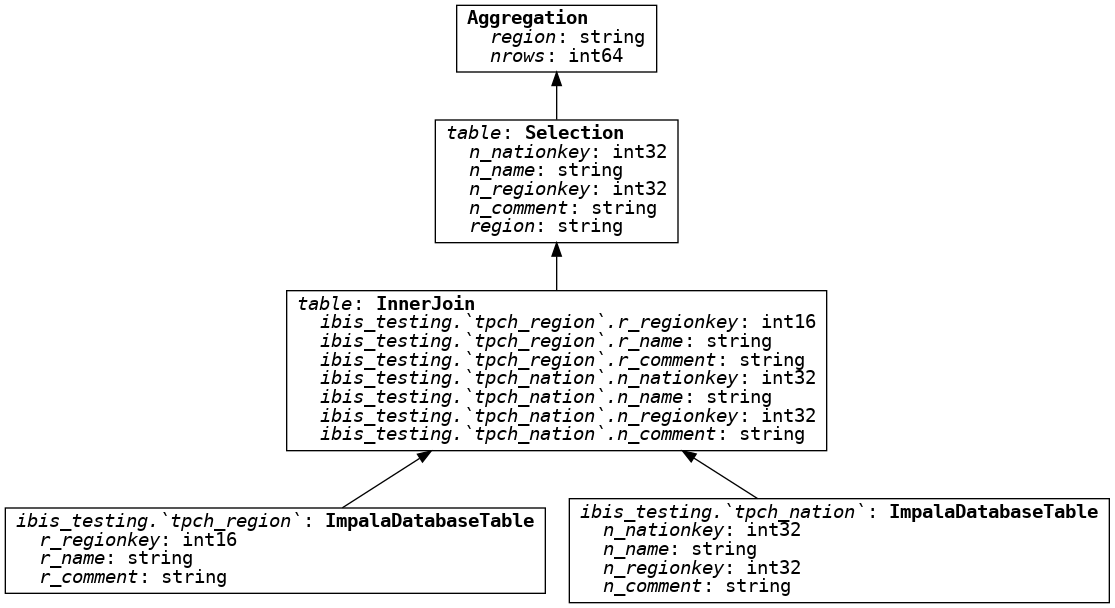

In [13]:
agged = table_ref.aggregate([table_ref.n_name.count().name('nrows')], by=['region'])
agged

Things like `group_by` work with unmaterialized joins, too, as you would hope. 

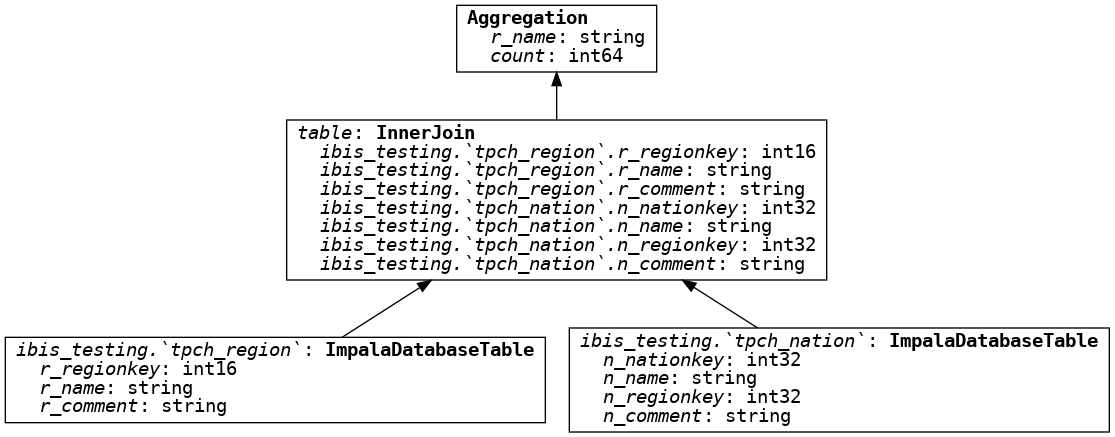

In [14]:
joined.group_by(region.r_name).size()

### Explicit join materialization

If you're lucky enough to have two table schemas with no overlapping column names (lucky you!), the join can be *materialized* without having to perform some other relational algebra operation:

    joined = a.inner_join(b, join_expr).materialize()
    
Note that this is equivalent to doing

    joined = a.join(b, join_expr)[a, b]
   
i.e., joining and then selecting all columns from both joined tables. If there is a name overlap, just like with the equivalent projection, there will be an immediate error.

### Writing down join keys

In addition to having explicit comparison expressions as join keys, you can also write down column names, or use expressions referencing the joined tables, e.g.:

    joined = a.join(b, [('a_key1', 'b_key2')])
    
    joined2 = a.join(b, [(left_expr, right_expr)])

    joined3 = a.join(b, ['common_key'])

These will be compared for equality when performing the join; if you want non-equality conditions in the join, you will have to form those yourself.

### Join referential nuances

There's nothing to stop you from doing many joins in succession, and, in fact, with complex schemas it will be to your advantage to build the joined table references for your analysis first, then reuse the objects as you go:

    joined_ref = (a.join(b, a.key1 == b.key2)
                   .join(c, [a.key3 == c.key4, b.key5 == c.key6]))

Note that, at least right now, you need to provide explicit comparison expressions (or tuples of column references) referencing the joined tables.

### Aggregating joined table with metrics involving more than one base reference

Let's consider the case similar to the SQL query

    SELECT a.key, sum(a.foo - b.bar) AS metric
    FROM a
      JOIN b
        ON a.key = b.key
    GROUP BY 1
    
I'll use a somewhat contrived example using the data we already have to show you what this looks like. Take the `functional.alltypes` table, and suppose we want to compute the **mean absolute deviation (MAD) from the hourly mean of the double_col**. Silly, I know, but bear with me.

First, the hourly mean:

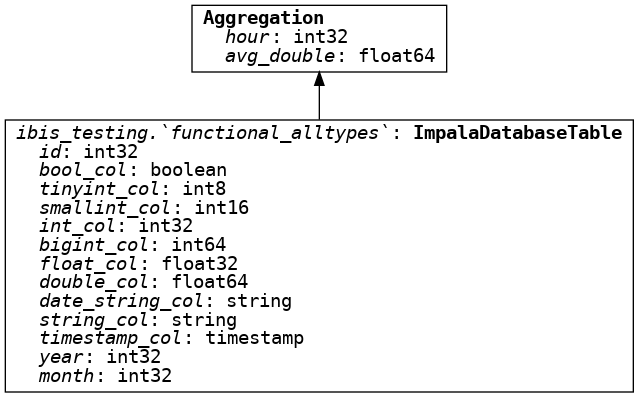

In [15]:
table = con.table('functional_alltypes')

hour_dim = table.timestamp_col.hour().name('hour')

hourly_mean = (table.group_by(hour_dim)
               .aggregate([table.double_col.mean().name('avg_double')]))
hourly_mean

Okay, great, now how about the MAD? The only trick here is that we can form an aggregate metric from the two tables, and we then have to join it later. Ibis **will not** figure out how to join the tables automatically for us. 

In [16]:
mad = (table.double_col - hourly_mean.avg_double).abs().mean().name('MAD')

This metric is only valid if used in the context of `table` joined with `hourly_mean`, so let's do that. Writing down the join condition is simply a matter of writing:

In [17]:
join_expr = hour_dim == hourly_mean.hour

Now let's compute the MAD grouped by `string_col`

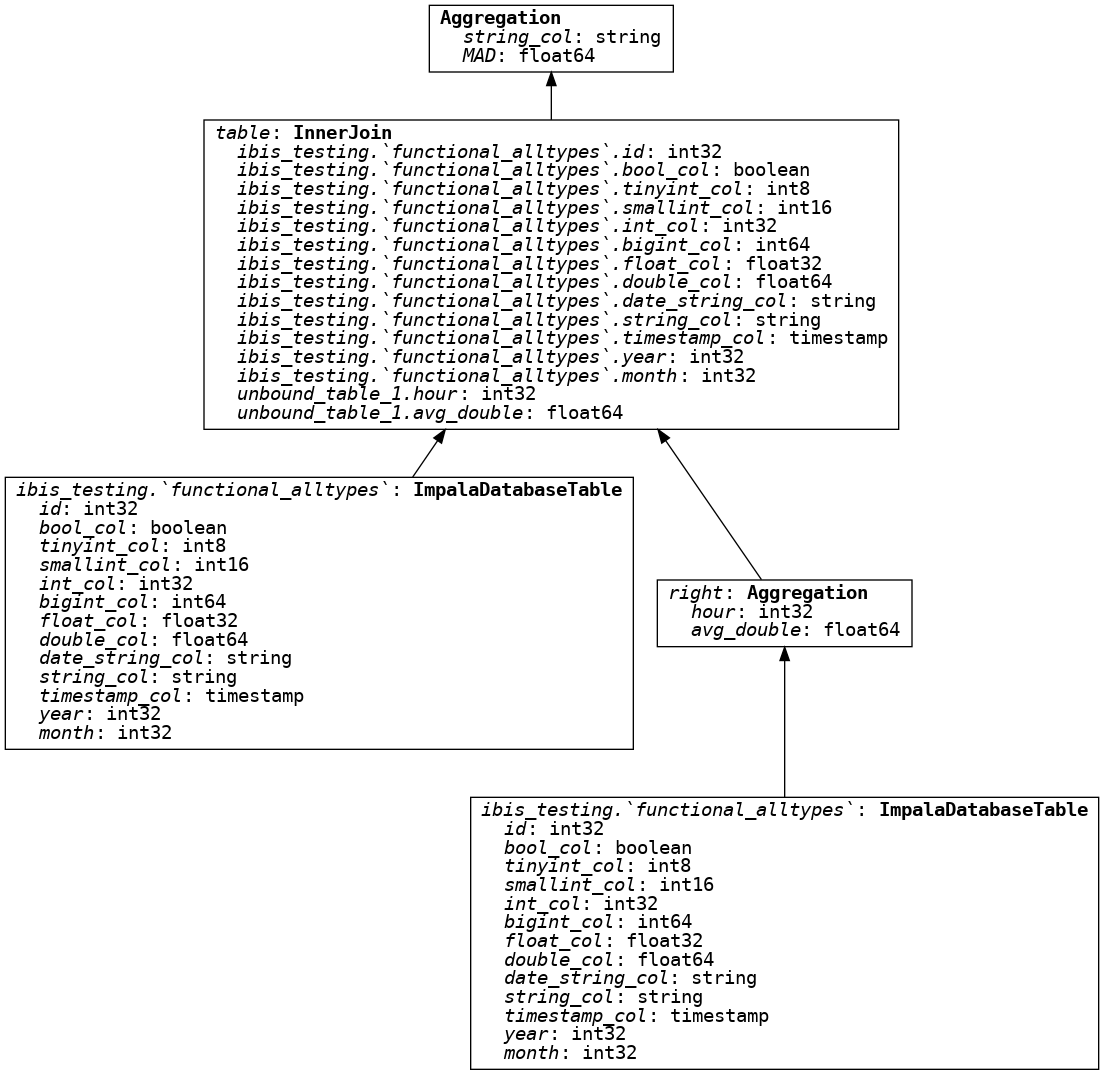

In [18]:
result = (table.inner_join(hourly_mean, join_expr)
          .group_by(table.string_col)
          .aggregate([mad]))
result

## Sorting

Sorting tables works similarly to the SQL `ORDER BY` clause. We use the `sort_by` function and pass one of the following:

- Column names
- Column expressions
- One of these, with a False (descending order) or True (ascending order) qualifier

So, to sort by `total` in ascending order we write:

    table.sort_by('total')

or by `key` then by `total` in descending order

    table.sort_by(['key', ('total', False)])
    
For descending sort order, there is a convenience function `desc` which can wrap sort keys

    from ibis import desc
    table.sort_by(['key', desc(table.total)])

Here's a concrete example involving filters, custom grouping dimension, and sorting

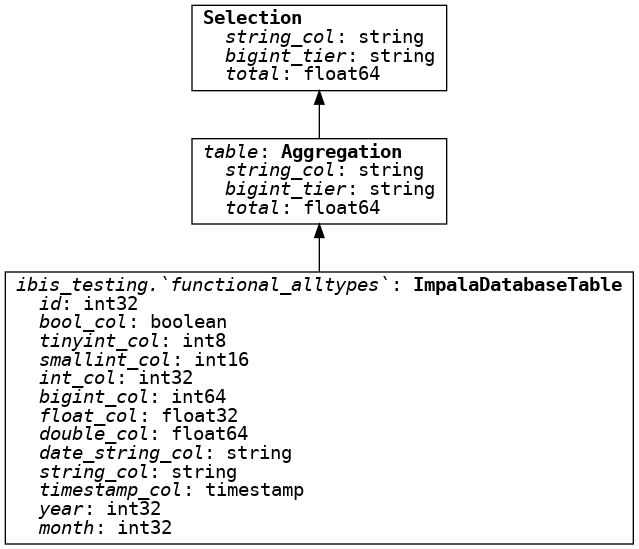

In [19]:
table = con.table('functional_alltypes')

keys = ['string_col', (table.bigint_col > 40).ifelse('high', 'low').name('bigint_tier')]
metrics = [table.double_col.sum().name('total')]

agged = (table
         .filter(table.int_col < 8)
         .group_by(keys)
         .aggregate(metrics))

sorted_agged = agged.sort_by(['bigint_tier', ('total', False)])
sorted_agged

For sorting in descending order, you can use the special `ibis.desc` function:

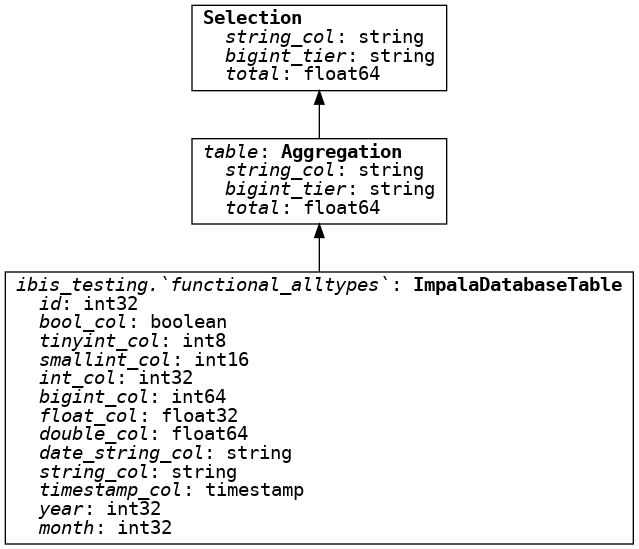

In [20]:
agged.sort_by(ibis.desc('total'))